# **STEP 1: Load and Split MNIST**

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# 60,000 train / 10,000 test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


# **STEP 2: Train SGD + Random Forest**

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# SGD with hinge loss = linear SVM
sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# **STEP 3: Evaluate Both Models**

In [3]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate SGD
y_pred_sgd = sgd_clf.predict(X_test)
print("SGD Classifier Report:\n", classification_report(y_test, y_pred_sgd))
print("SGD Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sgd))

# Evaluate Random Forest
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


SGD Classifier Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       980
           1       0.97      0.96      0.97      1135
           2       0.93      0.78      0.85      1032
           3       0.78      0.92      0.84      1010
           4       0.96      0.79      0.87       982
           5       0.86      0.79      0.83       892
           6       0.96      0.89      0.93       958
           7       0.93      0.89      0.91      1028
           8       0.65      0.90      0.75       974
           9       0.84      0.87      0.86      1009

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.87     10000
weighted avg       0.89      0.87      0.88     10000

SGD Confusion Matrix:
 [[ 902    0    8   11    1   13    2    4   39    0]
 [   0 1095    2    3    0    2    4    1   28    0]
 [   1   10  803   69    6    4    4   10  122    3]
 [   0    1    6  931    1   21    

# **STEP 4: Visualize Worst Errors (on Random Forest)**

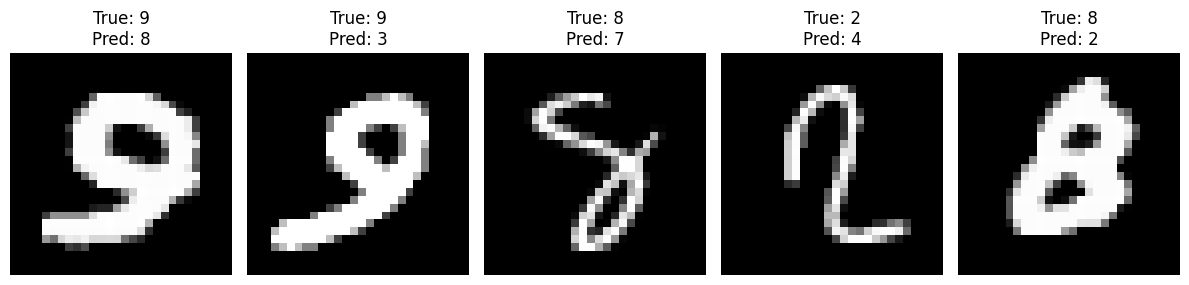

In [4]:
import matplotlib.pyplot as plt

# Find worst predictions (misclassified with lowest confidence)
probs = rf_clf.predict_proba(X_test)
wrong = (y_pred_rf != y_test)

# Confidence of predicted class
confidences = probs[range(len(probs)), y_pred_rf]
worst_indices = np.argsort(confidences[wrong])[:5]  # 5 worst

fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for ax, idx in zip(axes, np.where(wrong)[0][worst_indices]):
    ax.imshow(X_test[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[idx]}\nPred: {y_pred_rf[idx]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


# **STEP 5: Gradio App**

In [5]:
import gradio as gr
import numpy as np
from PIL import Image, ImageOps
from skimage.transform import resize

def predict_digit(image):
    try:
        if not isinstance(image, np.ndarray):
            return {"error": "No drawing detected. Please draw a digit first."}

        # Convert to grayscale (RGB or RGBA)
        if image.shape[-1] == 4:
            image = Image.fromarray(image[:, :, :3]).convert("L")
        else:
            image = Image.fromarray(image).convert("L")

        # Invert to match MNIST
        image = ImageOps.invert(image)

        # Resize to 28x28
        image_resized = resize(np.array(image), (28, 28), mode="constant", anti_aliasing=False)

        # Flatten and scale
        image_flattened = image_resized.reshape(1, -1) * 255.0

        # Predict
        probs = rf_clf.predict_proba(image_flattened)[0]
        return {str(i): float(probs[i]) for i in range(10)}

    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST Digit Recognizer (Random Forest)",
    description="Draw a digit (0–9) and get top 3 predictions."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0bd303264807f24ad9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Final Accuracy Check**

In [ ]:
from sklearn.metrics import accuracy_score

print("SGD Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))  # Should be >95%
